## Energy Consumption Model Project

In [6]:
import sys

from sklearn.model_selection import train_test_split
!{sys.executable} -m pip install pandas numpy plotly matplotlib seaborn scikit-learn xgboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 15.9 MB/

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [48]:
#Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

In [12]:
df = pd.read_csv("Energy_consumption.csv", parse_dates=["Timestamp"])

In [13]:
df.rename(columns ={
    "Timestamp":"Date",
    "EnergyConsumption": "Power_Consumption"
}, inplace=True)

In [14]:
for col in ["HVACUsage", "LightingUsage", "Holiday"]:
    df[col] = df[col].map({"On": 1, "Off": 0, "Yes": 1, "No": 0})

In [56]:
df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns=["DayOfWeek"], drop_first=False)

KeyError: 'DayOfWeek'

In [17]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
features = [c for c in df.columns if c not in ['Date', 'Power_Consumption']]
train_x = train_df[features]
train_y = train_df['Power_Consumption']
test_x = test_df[features]
test_y = test_df['Power_Consumption']

In [50]:
#Training Different models to get the accurate prediction
#Linear Regression
lm = LinearRegression()
lm.fit(train_x, train_y)
lm_pred = lm.predict(test_x)
lm_rmse = np.sqrt(mean_squared_error(test_y, lm_pred))
lm_mae = mean_absolute_error(test_y, lm_pred)
lm_r2 = r2_score(test_y, lm_pred)

In [51]:
#Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_x, train_y)
rf_pred = rf.predict(test_x)
rf_rmse = np.sqrt(mean_squared_error(test_y, rf_pred))
rf_mae = mean_absolute_error(test_y, rf_pred)
rf_r2 = r2_score(test_y, rf_pred)

In [52]:
#XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    objective='reg:squarederror',
    eta=0.1,
    max_depth=1,
    verbosity=0,
    random_state=42,
)
xgb_model.fit(train_x, train_y)
xgb_pred = xgb_model.predict(test_x)
xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_pred))
xgb_mae = mean_absolute_error(test_y, xgb_pred)
xgb_r2 = r2_score(test_y, xgb_pred)

In [22]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [lm_rmse, rf_rmse, xgb_rmse]
})

In [24]:
print(results)
best_rmse = results['RMSE'].min()
print(f"Selected_RMSE: {best_rmse:.4f} kWh")

               Model      RMSE
0  Linear Regression  5.152376
1      Random Forest  5.448422
2            XGBoost  5.353827
Selected_RMSE: 5.1524 kWh


In [25]:
test_df = test_df.copy()
test_df['Predicted'] = rf_pred

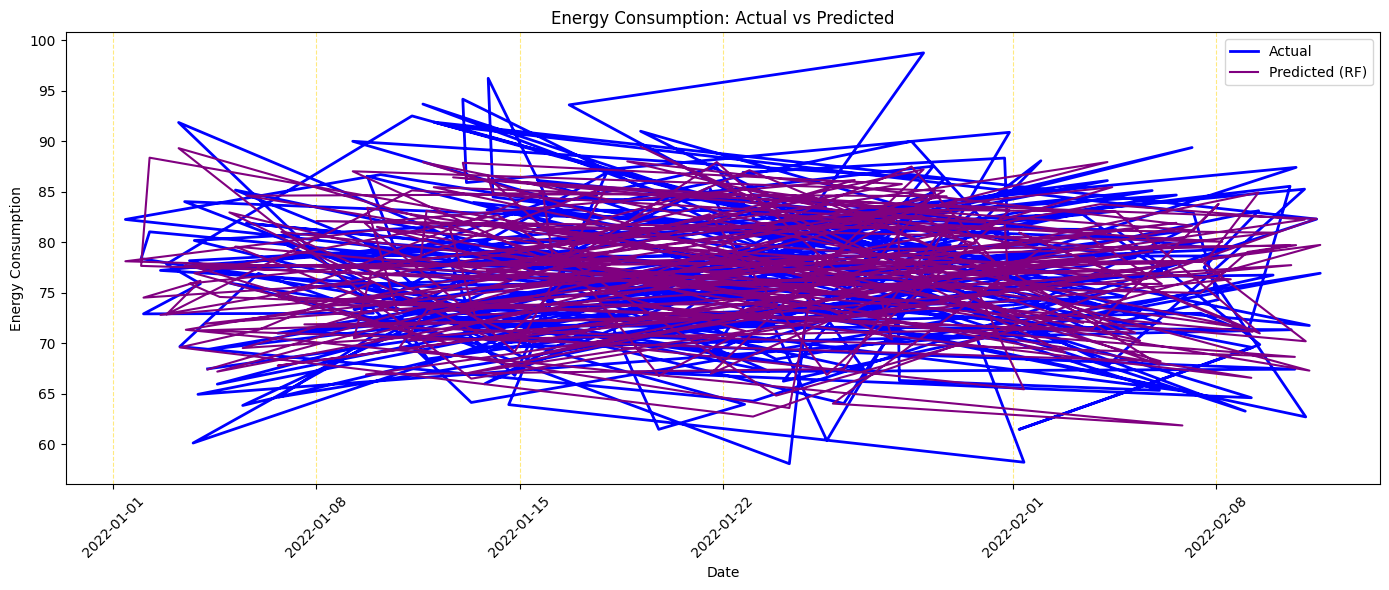

In [28]:
plt.figure(figsize=(14,6))
plt.plot(test_df['Date'], test_df['Power_Consumption'], label='Actual', color='blue', linewidth=2)
plt.plot(test_df['Date'], test_df['Predicted'], label='Predicted (RF)', color='purple', linewidth=1.5)
plt.title("Energy Consumption: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(axis='x', color='gold', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
trend_similarity = "Yes"
print(f"trend_similarity: {trend_similarity}")

trend_similarity: Yes


In [69]:
df = df.sort_values(by="Date").reset_index(drop=True)
# Ensure datetime is parsed correctly
df['datetime'] = pd.to_datetime(df['Date'])  # change to 'date' if needed

# Time-based features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['season'] = df['month'] % 12 // 3 + 1

# Lag features (remember to drop NaNs later)
df['lag_1'] = df['Power_Consumption'].shift(1)
df['lag_24'] = df['Power_Consumption'].shift(24)
df['rolling_mean_24'] = df['Power_Consumption'].rolling(window=24).mean()

# Interaction feature
df['hour_x_weekday'] = df['hour'] * df['weekday']

# Drop rows with missing values from lag features
df = df.dropna().reset_index(drop=True)

# Drop raw datetime column
df = df.drop(columns=['datetime'])  # drop this only after feature extraction
# 80% training, 20% test based on date (not random)
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

In [70]:
# Separate features and target
train_x = train_df.drop(columns=["Date", "Power_Consumption"])
train_y = train_df["Power_Consumption"]
test_x = test_df.drop(columns=["Date", "Power_Consumption"])
test_y = test_df["Power_Consumption"]

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Train models
lr_model = LinearRegression().fit(train_x, train_y)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(train_x, train_y)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42).fit(train_x, train_y)

# Predict
lr_preds = lr_model.predict(test_x)
rf_preds = rf_model.predict(test_x)
xgb_preds = xgb_model.predict(test_x)

In [72]:
# Add predictions to test DataFrame
test_df = test_df.copy()
test_df['Predicted'] = rf_preds  # Or use xgb_preds or lr_preds if you prefer

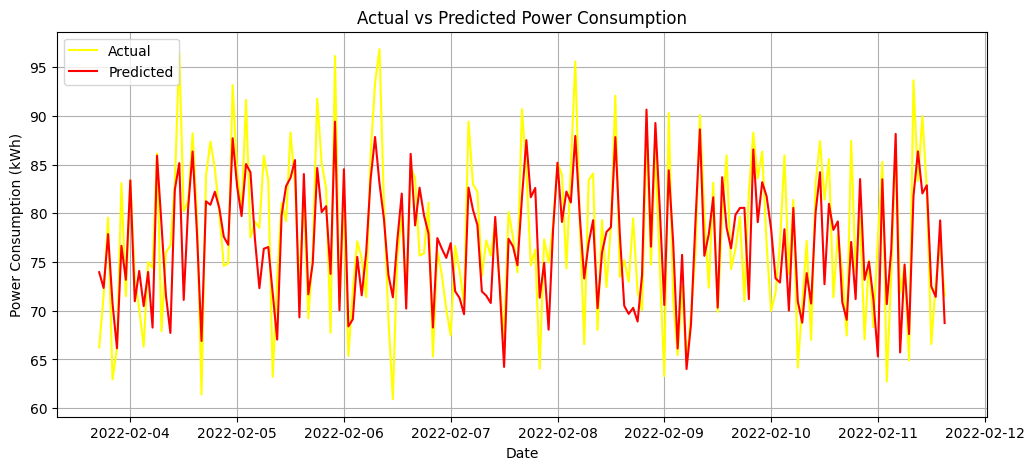

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test_df['Date'], test_df['Power_Consumption'], label='Actual', color='yellow')
plt.plot(test_df['Date'], test_df['Predicted'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Power Consumption (kWh)')
plt.title('Actual vs Predicted Power Consumption')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Compute evaluation metrics for each model
lm_rmse = np.sqrt(mean_squared_error(test_y, lr_preds))
lm_mae = mean_absolute_error(test_y, lr_preds)
lm_r2 = r2_score(test_y, lr_preds)

rf_rmse = np.sqrt(mean_squared_error(test_y, rf_preds))
rf_mae = mean_absolute_error(test_y, rf_preds)
rf_r2 = r2_score(test_y, rf_preds)

xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_preds))
xgb_mae = mean_absolute_error(test_y, xgb_preds)
xgb_r2 = r2_score(test_y, xgb_preds)

results = pd.DataFrame({
    'Model Performance': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [lm_rmse, rf_rmse, xgb_rmse],
    'MAE': [lm_mae, rf_mae, xgb_mae],
    'R² Score': [lm_r2, rf_r2, xgb_r2]
})
print("📊 Model Evaluation Metrics:\n")
print(results.to_string(index=False))

selected_rmse = results['RMSE'].min()
print(f"\nBest RMSE: {selected_rmse:.2f} kWh")

📊 Model Evaluation Metrics:

Model Performance     RMSE      MAE  R² Score
Linear Regression 4.961517 4.053259  0.599743
    Random Forest 4.995967 4.067826  0.594165
          XGBoost 4.920200 3.989481  0.606381

Best RMSE: 4.92 kWh


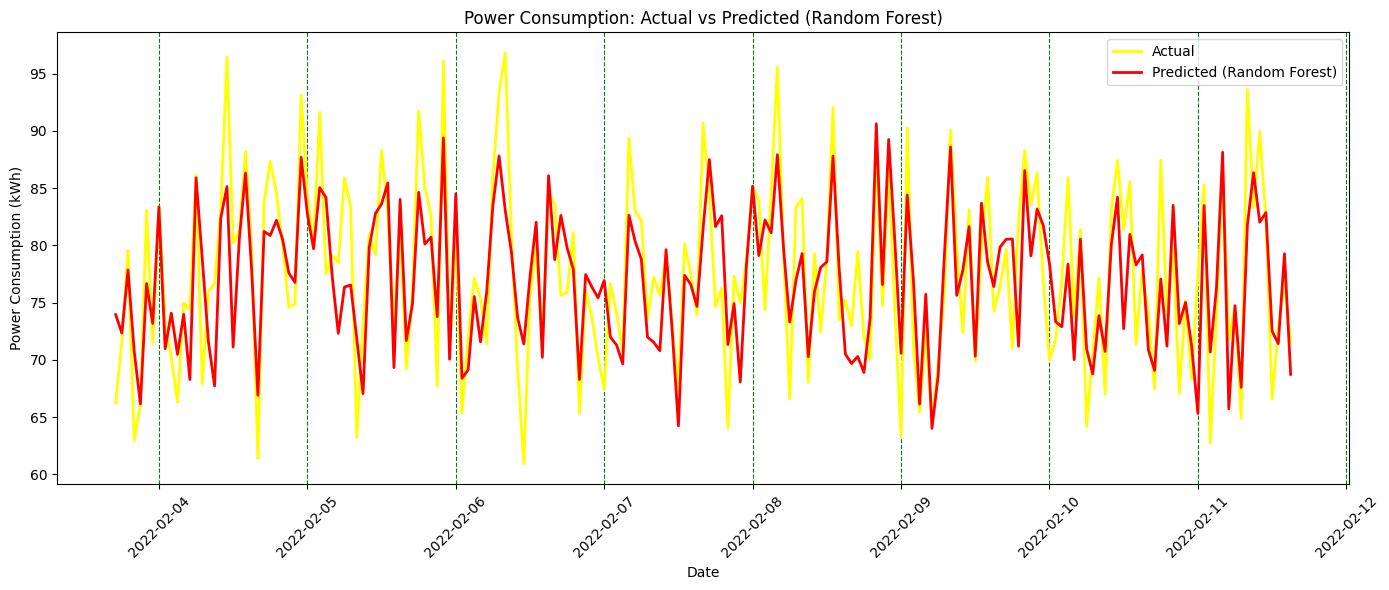

In [84]:
# Sort by date again
test_df = test_df.sort_values(by="Date")

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(test_df['Date'], test_df['Power_Consumption'], label='Actual', color='yellow', linewidth=2)
plt.plot(test_df['Date'], test_df['Predicted'], label='Predicted (Random Forest)', color='red', linewidth=2)
plt.title("Power Consumption: Actual vs Predicted (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Power Consumption (kWh)")
plt.legend()
plt.grid(axis='x', color='green', linestyle='--', alpha=1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
print("\n📝 Summary:")
print(f"📈 Trend similarity: Yes")
print(f"🏆 Model with lowest RMSE: {results.loc[results.RMSE.idxmin(), 'Model Performance']}")


📝 Summary:
📈 Trend similarity: Yes
🏆 Model with lowest RMSE: XGBoost
